In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the modules directory to Python path
module_path = os.path.abspath(os.path.join('..', 'scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)

#import modules
from scraper import main as run_scraper
from preprocessor import ReviewPreprocessor
from sentiment_analysis import BankReviewAnalyzer

In [2]:
print("[ Starting Scraper... ]")

# Run the main scraper function
raw_df = run_scraper()

print("\n[INFO] ------   Scraping Finished.   ------")
display(raw_df.head())

[ Starting Scraper... ]

===== Starting Google Play Store Review Scraper =====


[1/2] Fetching app information...

CBE: Commercial Bank Of Ethiopia
App ID: com.combanketh.mobilebanking
Current Rating: 4.3197813
Total Ratings: 38875
Total Reviews: 8337

BOA: Bank Of Abissinia
App ID: com.boa.boaMobileBanking
Current Rating: 4.172414
Total Ratings: 6372
Total Reviews: 1221

DashenBank: Dashen Bank S.c.
App ID: com.dashen.dashensuperapp
Current Rating: 4.1581507
Total Ratings: 3917
Total Reviews: 779

App information saved to data/raw/app_info.csv

[2/2] Scraping reviews...


Banks:   0%|          | 0/3 [00:00<?, ?it/s]

scraping reviews for: com.combanketh.mobilebanking ...
420 amount of data is scraped
Collected 420 reviews for Commercial Bank Of Ethiopia


Banks:  33%|███▎      | 1/3 [00:03<00:07,  3.79s/it]

scraping reviews for: com.boa.boaMobileBanking ...
420 amount of data is scraped
Collected 420 reviews for Bank Of Abissinia


Banks:  67%|██████▋   | 2/3 [00:07<00:03,  3.72s/it]

scraping reviews for: com.dashen.dashensuperapp ...
420 amount of data is scraped
Collected 420 reviews for Dashen Bank S.c.


Banks: 100%|██████████| 3/3 [00:11<00:00,  3.74s/it]



===== Scraping Complete! =====


Total reviews collected: 1260
Reviews per bank:
  Commercial Bank Of Ethiopia: 420
  Bank Of Abissinia: 420
  Dashen Bank S.c.: 420

Data saved to: data/raw/reviews_raw.csv

===== Sample Reviews =====

Commercial Bank Of Ethiopia:
------------------------------------------------------------

Rating: ⭐⭐⭐⭐⭐
Review: CBE ይለያል።...
Date: 2025-11-29 17:22:32

Rating: ⭐⭐⭐⭐⭐
Review: it's special for me...
Date: 2025-11-29 15:54:14

Rating: ⭐⭐
Review: Make it user friendly....
Date: 2025-11-29 08:17:45

Bank Of Abissinia:
------------------------------------------------------------

Rating: ⭐⭐⭐⭐⭐
Review: 🙏👍...
Date: 2025-11-29 03:47:54

Rating: ⭐⭐⭐⭐⭐
Review: Very Good...
Date: 2025-11-28 20:18:20

Rating: ⭐⭐⭐⭐⭐
Review: goof...
Date: 2025-11-28 13:33:37

Dashen Bank S.c.:
------------------------------------------------------------

Rating: ⭐⭐⭐⭐⭐
Review: very smart App easy to use and friendly...
Date: 2025-11-29 16:22:04

Rating: ⭐⭐⭐⭐⭐
Review: Very exemplery App

,review_id,review_text,rating,review_date,user_name,thumbs_up,reply_content,bank_code,bank_name,app_id,source
0,cb37b096-e071-4f0f-a8fd-067b7d71706d,CBE ይለያል።,5,2025-11-29 17:22:32,Kamil Tesfaye,0,None,CBE,Commercial Bank Of Ethiopia,5.2.1,Google Play
1,70f504ff-daed-40d9-9c89-cc49a95ef659,it's special for me,5,2025-11-29 15:54:14,Abde Semed,0,None,CBE,Commercial Bank Of Ethiopia,5.2.1,Google Play
2,28f229b5-0026-41b9-a1eb-b76e74736f63,Make it user friendly.,2,2025-11-29 08:17:45,TOMIZ Creativity,0,None,CBE,Commercial Bank Of Ethiopia,None,Google Play
3,68d8daea-db47-4e23-a692-755173dea983,maaliif daddafee install gaafata,3,2025-11-28 13:36:32,Tesfaye Abdi,0,None,CBE,Commercial Bank Of Ethiopia,5.2.1,Google Play
4,ee0dbb0e-4eb0-47b5-9874-c37877493f99,good app,5,2025-11-28 11:33:17,Betelhem Kebede,0,None,CBE,Commercial Bank Of Ethiopia,None,Google Play


In [3]:

preprocessor = ReviewPreprocessor()
success = preprocessor.process()

if success:
    print("\n Preprocessing finished successfully!")
    df = preprocessor.df
else:
    print(" Preprocessing failed.")

STARTING DATA PREPROCESSING
Loading raw data...
Loaded 1260 reviews

[1/6] Checking for missing data...

Missing values:
  reply_content: 1258 (99.84%)
  app_id: 290 (23.02%)

[2/6] Handling missing values...

[3/6] Normalizing dates...
Date range: 2024-09-15 to 2025-11-29

[4/6] Cleaning text...
Removed 34 reviews with empty text

[5/6] Validating ratings...
All ratings are valid (1-5)

[6/6] Preparing final output...
Final dataset: 1226 reviews

Saving processed data...
Data saved to: data/processed/reviews_processed.csv

PREPROCESSING REPORT

Original records: 1260
Records with missing critical data: 0
Empty reviews removed: 34
Invalid ratings removed: 0
Final records: 1226

Data retention rate: 97.30%
Data error rate: 2.70%
✓ Data quality: EXCELLENT (<5% errors)

Reviews per bank:
  Commercial Bank Of Ethiopia: 411
  Bank Of Abissinia: 408
  Dashen Bank S.c.: 407

Rating distribution:
  ⭐⭐⭐⭐⭐: 753 (61.4%)
  ⭐⭐⭐⭐: 90 (7.3%)
  ⭐⭐⭐: 69 (5.6%)
  ⭐⭐: 45 (3.7%)
  ⭐: 269 (21.9%)

Date ran

===== sentiment analysis started =====
Data loaded successfully: 1226 reviews
Found 3 banks: ['Bank Of Abissinia', 'Commercial Bank Of Ethiopia', 'Dashen Bank S.c.']
  - Bank Of Abissinia: 408 reviews
  - Commercial Bank Of Ethiopia: 411 reviews
  - Dashen Bank S.c.: 407 reviews
Preprocessing completed for combined: 1226 reviews
Preprocessing completed for Bank Of Abissinia: 408 reviews
Preprocessing completed for Commercial Bank Of Ethiopia: 411 reviews
Preprocessing completed for Dashen Bank S.c.: 407 reviews

ANALYZING: Bank Of Abissinia

Basic Statistics for Bank Of Abissinia:
  - Total Reviews: 408
  - Average Rating: 3.41
  - Sentiment Distribution: {'positive': 236, 'negative': 148, 'neutral': 24}

Top 10 frequent words for Bank Of Abissinia:
  app: 155
  good: 65
  bank: 45
  best: 31
  boa: 29
  mobile: 25
  work: 25
  banking: 25
  use: 22
  money: 21

Top 10 TF-IDF words for Bank Of Abissinia:
  good: 0.1198
  app: 0.0753
  best: 0.0503
  nice: 0.0312
  boa: 0.0286
  bank: 0

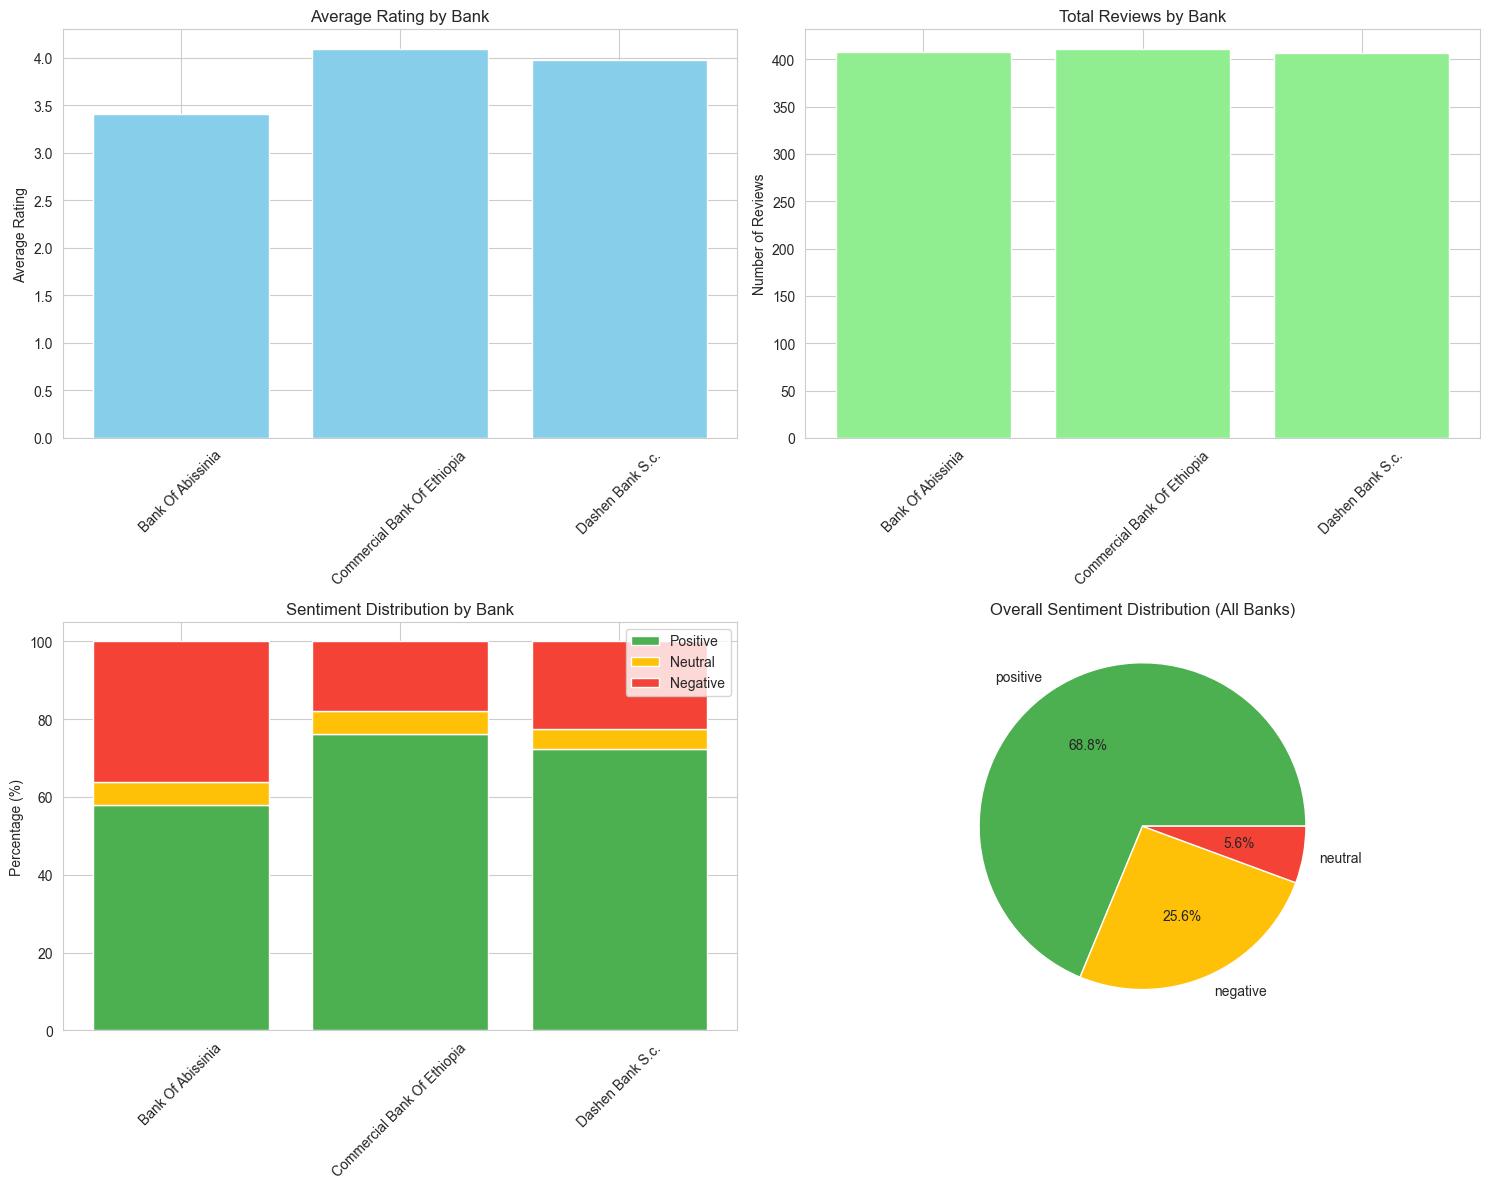

Report saved: bank_reports\bank_of_abissinia_analysis.csv
Report saved: bank_reports\commercial_bank_of_ethiopia_analysis.csv
Report saved: bank_reports\dashen_bank_s.c._analysis.csv

 sentiment analysis finished successfully!


In [4]:
print("===== sentiment analysis started =====")
analyzer=BankReviewAnalyzer()   #initializing
analyzer.run_complete_multi_bank_analysis('./data/processed/reviews_processed.csv')  #performing compleet analysis

if analyzer:
    print("\n sentiment analysis finished successfully!")
else:
    print("\n sentiment alalysis failed.")

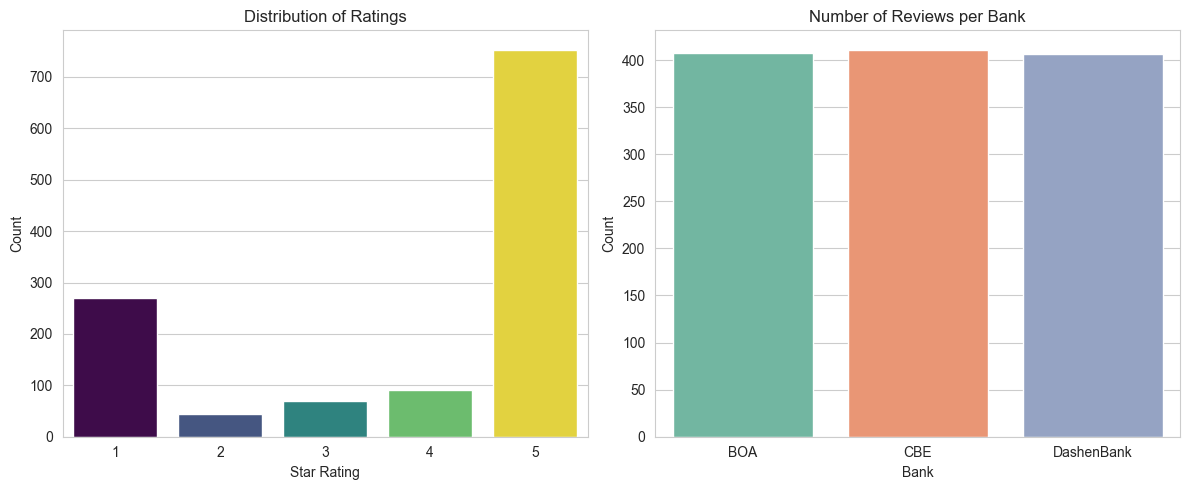

In [5]:
# Set plot style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 5))

# 1. Ratings Distribution
plt.subplot(1, 2, 1)
sns.countplot(x='rating', data=df, hue='rating', palette='viridis', legend=False)
plt.title('Distribution of Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Count')

# 2. Reviews per Bank
plt.subplot(1, 2, 2)
sns.countplot(x='bank_code', data=df, hue='bank_code', palette='Set2', legend=False)
plt.title('Number of Reviews per Bank')
plt.xlabel('Bank')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

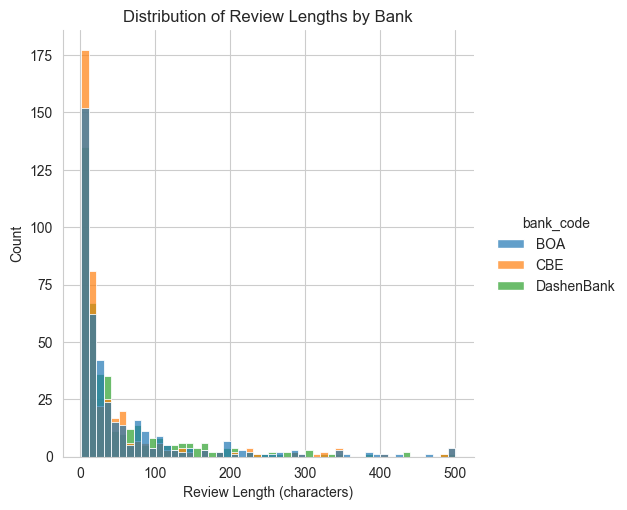

In [6]:
# 3. Review Length Distribution
plt.figure(figsize=(10, 6))
sns.displot(data=df, x='text_length', hue='bank_code', kind='hist', 
            bins=50, alpha=0.7, multiple="layer")
plt.title('Distribution of Review Lengths by Bank')
plt.xlabel('Review Length (characters)')
plt.ylabel('Count')
plt.show()

In [6]:

module_path = os.path.abspath(os.path.join('..', 'config'))
if module_path not in sys.path:
    sys.path.append(module_path)

import psycopg2 
from psycopg2.extras import execute_values
import pandas as pd
from config import DB_CONFIG_

In [2]:
DB_CONFIG={
    'host':DB_CONFIG_['DB_HOST'],
    'database':DB_CONFIG_['DB_NAME'],
    'user':DB_CONFIG_['DB_USER'],
    'password':DB_CONFIG_['DB_PASSWORD'],
    'port':DB_CONFIG_['DB_PORT']
}

df_bank_data=pd.read_csv("./data/raw/app_info.csv")
CSV_DIR="./bank_reports"

In [3]:
try:
    conn=psycopg2.connect(**DB_CONFIG)
    cur=conn.cursor()
    print("database connected successfully")
except Exception as e:
    print("error connecting to database")

database connected successfully


In [16]:
print(f"loaded {len(df_bank_data)} bank data")
#insert data to db
if conn and cur:
    for _,row in df_bank_data.iterrows():
        try:
            cur.execute(
                """insert into banks (bank_name,app_name)
                 VALUES (%s, %s)
                ON CONFLICT (bank_name) DO NOTHING""",
                (row['bank_name'],row['title'])
            )
        except Exception as e:
            print(f"error inserting data")
    conn.commit()
    print("data inserted successfully!")

loaded 3 bank data
data inserted successfully!


In [17]:
# # Get bank mapping from database
if conn and cur:
    cur.execute("SELECT bank_id, bank_name FROM banks")
    bank_mapping = {row[1]: row[0] for row in cur.fetchall()}
    
    print("Bank mapping (bank_name -> bank_id):")
    for bank_name, bank_id in bank_mapping.items():
        print(f"  {bank_name}: {bank_id}")


Bank mapping (bank_name -> bank_id):
  Commercial Bank Of Ethiopia: 1
  Bank Of Abissinia: 2
  Dashen Bank S.c.: 3


In [24]:
# Get bank mapping
cur.execute("SELECT bank_id, bank_name FROM banks")
bank_mapping = {str(bank_name).strip(): bank_id for bank_id, bank_name in cur.fetchall()}

In [25]:
import glob
# Get CSV files
csv_files = glob.glob(os.path.join(CSV_DIR, "*.csv"))
total_inserted = 0

for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    bank_name = str(df['bank_name'].iloc[0]).strip()
    
    # Find bank_id (case-insensitive)
    bank_id = bank_mapping.get(bank_name)
    if not bank_id:
        for db_name, db_id in bank_mapping.items():
            if db_name.lower() == bank_name.lower():
                bank_id = db_id
                break
    
    if not bank_id:
        print(f"Skipping {csv_file}: Bank '{bank_name}' not found in database")
        continue
    
    # Prepare data
    insert_data = []
    for _, row in df.iterrows():
        insert_data.append((
            row['review_id'],
            bank_id,
            str(row['review_text']),
            row['review_date'],
            str(row.get('sentiment_label', 'neutral')),
            float(row.get('sentiment_score', 0.0)),
            str(row.get('source', 'bank_reports'))
        ))
    
    # Insert data
    if insert_data:
        execute_values(
            cur,
            """
            INSERT INTO reviews (
                review_id, bank_id, review_text, review_date, 
                sentiment_label, sentiment_score, source_
            ) VALUES %s
            ON CONFLICT (review_id) DO NOTHING
            """,
            insert_data
        )
        
        inserted = cur.rowcount
        total_inserted += inserted
        conn.commit()
        
        print(f"Inserted {inserted} reviews for {bank_name}")

print(f"\nTotal reviews inserted: {total_inserted}")

cur.close()
conn.close()

Inserted 8 reviews for Bank Of Abissinia
Inserted 11 reviews for Commercial Bank Of Ethiopia
Inserted 7 reviews for Dashen Bank S.c.

Total reviews inserted: 26


In [4]:
# Connect to PostgreSQL

conn = psycopg2.connect(
    host='localhost',
    database ='bank_reviews',
    user='postgres',
    password='1234',
    port='5432'
)
if conn:
    print(f"database conected successfully")

database conected successfully


In [ ]:
#displaying results

def run_query(sql):
    return pd.read_sql(sql,conn)

sql="select * from banks"

run_query(sql)

cur.close()
conn.close()

C:\Users\Acer\AppData\Local\Temp\ipykernel_2524\1417020023.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql,conn)


,bank_id,bank_name,app_name
0,1,Commercial Bank Of Ethiopia,Commercial Bank of Ethiopia
1,2,Bank Of Abissinia,BoA Mobile
2,3,Dashen Bank S.c.,Dashen Bank
